In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

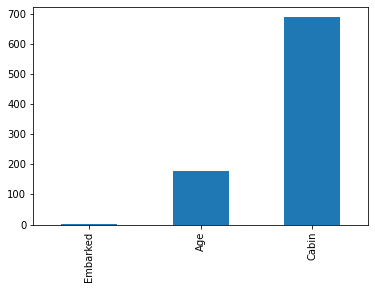

In [2]:
# read the train data
data_train = pd.read_csv('train.csv')
# missing values
data_train[data_train.columns[data_train.isna().sum() > 0]].isna().sum().sort_values().plot.bar();

In [3]:
# check where most people embarked
data_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [4]:
# replace null values in dataframe by 'S', the most common port
data_train['Embarked'] = data_train['Embarked'].replace(np.NaN, 'S')

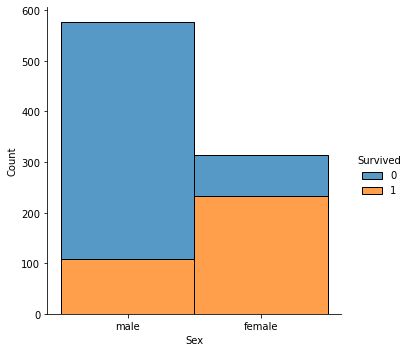

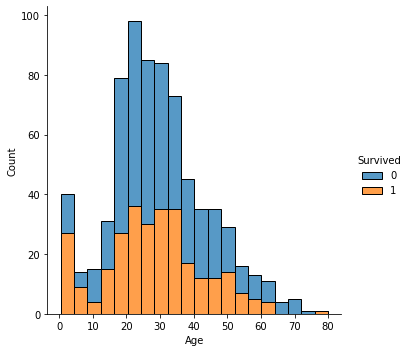

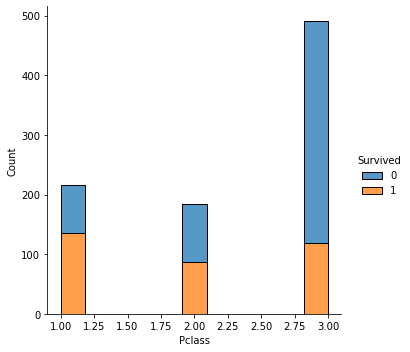

In [5]:
# Visualizing some aspects

# Count survivors by sex 
sns.displot(data_train, x='Sex', hue='Survived', multiple="stack");
# (most woman survived)

# Count survivors by age 
sns.displot(data_train, x='Age', hue='Survived', multiple="stack");
# (most children survived)

# Count survivors by class 
sns.displot(data_train, x='Pclass', hue='Survived', multiple="stack");
# (most people from 3th class didnt survived)

In [6]:
# As there are too many missing cabin numbers we are going to drop it
# Trying to replace them based on the relative small sample of cabin numbers could result
# in overfitting of train data, leading to poor prediction

# as there are several missing ages, replace null values by the mean value of ages
data_train['Age'] = data_train['Age'].replace(np.NaN, data_train['Age'].mean())

# get rid of train data columns unimportant to the death (name, ticket number)
data_train_short = data_train[['Survived','Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# convert string to number
data_train_short_X = data_train_short[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].values
# 1) gender:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['female','male'])
data_train_short_X[:,1] = le_sex.transform(data_train_short_X[:,1]) 

# 2) port of embarkation:
le_emb = preprocessing.LabelEncoder()
le_emb.fit(['C', 'Q', 'S'])
data_train_short_X[:,6] = le_emb.transform(data_train_short_X[:,6]) 

# target variable
data_train_short_Y = data_train_short['Survived'].values
data_train_short_X[0:5]

array([[3, 1, 22.0, 1, 0, 7.25, 2],
       [1, 0, 38.0, 1, 0, 71.2833, 0],
       [3, 0, 26.0, 0, 0, 7.925, 2],
       [1, 0, 35.0, 1, 0, 53.1, 2],
       [3, 1, 35.0, 0, 0, 8.05, 2]], dtype=object)

In [7]:
# Normalize data
data_train_short_X = preprocessing.StandardScaler().fit(data_train_short_X).transform(data_train_short_X.astype(float))

In [8]:
# train test split to check optimum k (done only with train dataset because we dont know y_test)
X_train, X_test, y_train, y_test = train_test_split( data_train_short_X, data_train_short_Y, test_size=0.3, random_state=4)

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

#mean_acc

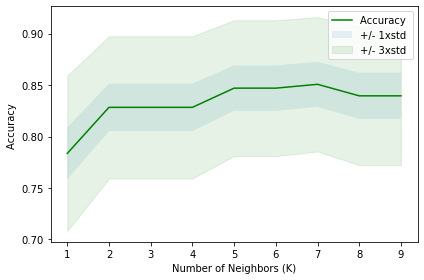

In [9]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [10]:
k = 7 # best result
# Update train Model for best k and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(data_train_short_X,data_train_short_Y)

In [11]:
# read test set:
data_test = pd.read_csv('test.csv')

# missing data
print(data_test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [12]:
# as there are several missing ages, replace null values by the mean value of ages
data_test['Age'] = data_test['Age'].replace(np.NaN, data_test['Age'].mean())

#replace null (nan) values of Fare by mean value
data_test['Fare'] = data_test['Fare'].replace(np.NaN, data_test['Fare'].mean() )

data_test_short = data_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# convert string to number
data_test_short_X = data_test_short[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].values
# 1) gender:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['female','male'])
data_test_short_X[:,1] = le_sex.transform(data_test_short_X[:,1])

# 2) port of embarkation:
le_emb = preprocessing.LabelEncoder()
le_emb.fit(['C', 'Q', 'S'])
data_test_short_X[:,6] = le_emb.transform(data_test_short_X[:,6]) 

In [13]:
# Normalize test set
data_test_short_X = preprocessing.StandardScaler().fit(data_test_short_X).transform(data_test_short_X.astype(float))

In [14]:
# Prediction
yhat = neigh.predict(data_test_short_X)
yhat[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [15]:
# Writing prediction to csv file
final = np.column_stack((data_test['PassengerId'], yhat)) # put PassengerId and yhat in two columns

np.savetxt("result10.csv", final , delimiter=",", header="PassengerId,Survived", fmt="%i", comments='')